In [1]:
# These settings are for the notebook only
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Import the required modules from the magrec package
from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.transformation.Mxy2Bsensor import Mxy2Bsensor
from magrec.method.CNN import CNN
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation
from magrec.misc.data import Data
from magrec import __datapath__

C:\Users\E123108\AppData\Local\Temp\ipykernel_22772\1633999039.py:16: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, BNV, kind='linear')
C:\Users\E123108\AppData\Local\Temp\ipykernel_22772\1633999039.py:19: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev

Applied a high frequency filter, removing all components smaller than 0.03 um


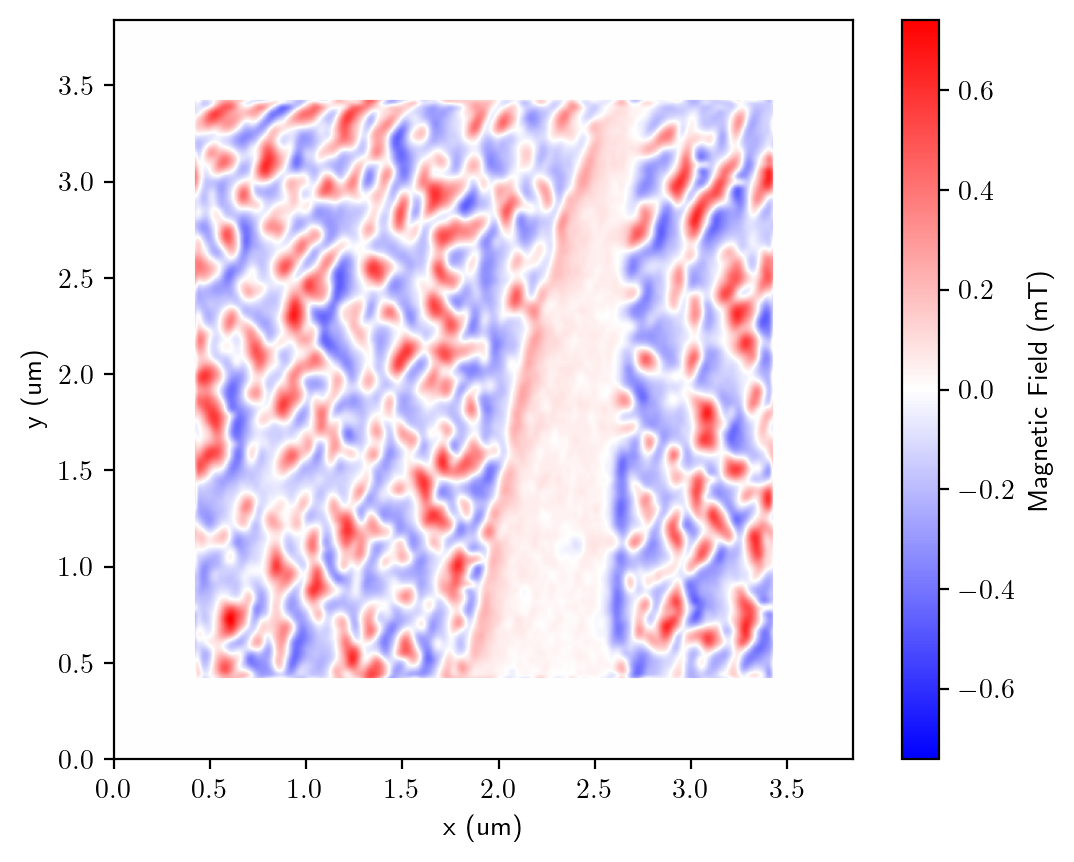

In [30]:
# Load the data from the database
f = open(__datapath__ / "Mz" / "MoirePatten_Stuttgart.lvm")
data = np.loadtxt(f).reshape(100,800)

# Convert the data into a magnetic field
BNV = 1e-6 *data[::,0:400] / (2.8e4)
# measured pixel size
dx = 3/400
dy = 3/100

# The data has an uneven number of points in the x and y direction
# This is can cause issues witht the reconstruction so we 
# interpolate the data to a regular grid
x = np.linspace(0,3,400)
y = np.linspace(0,3,100)
f = interpolate.interp2d(x, y, BNV, kind='linear')
xnew = np.linspace(0,3,400)
ynew = np.linspace(0,3,400)
BNV = f(xnew, ynew)

# updated pixel size
dx = 3/len(xnew)
dy = 3/len(ynew)

# Define the sensor parameters
sensor_theta = 53
sensor_phi = 282
height = 30e-3 # um
layer_thickness = 0

# initalise the dataset object and load the data
dataset = Data()
dataset.load_data(BNV, dx, dy, height, sensor_theta, sensor_phi, layer_thickness)

# Add spatial filters and perform other actions on the dataset 
dataset.add_hanning_filter(height)
dataset.add_short_wavelength_filter(height)
dataset.remove_DC_background()
# dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()

# Transform Bsensor into Bxyz

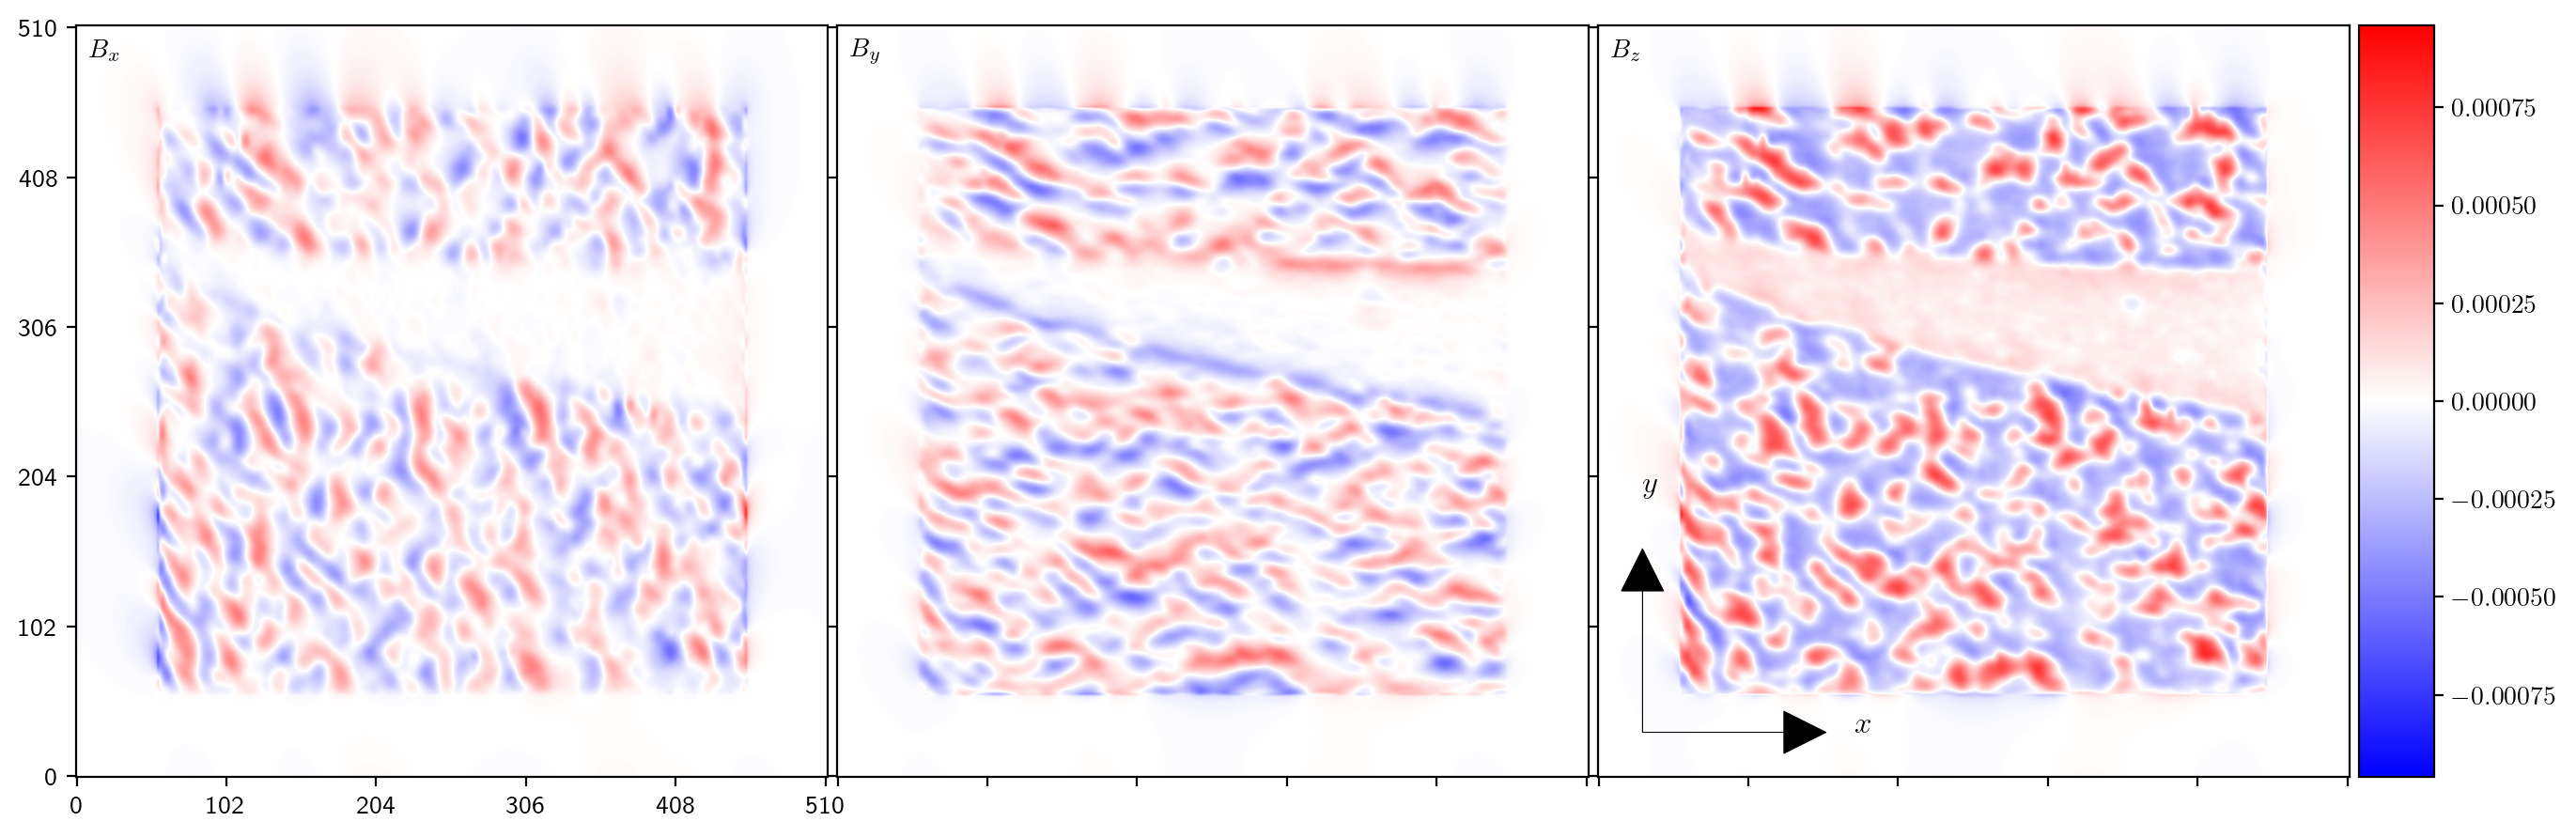

In [31]:
# Set the transformation to be performed on the data
dataset.set_transformer(MagneticFields)
# Perform the transformation
dataset.transform_data()

# Define the Bz data from the bx, by, and bz recontruction
Bx_data = dataset.transformed_target[0,::]
By_data = dataset.transformed_target[1,::]
Bz_data = dataset.transformed_target[2,::]

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

# Reconstruction of magnetisation with different approaches

no input provided, using the dataset target


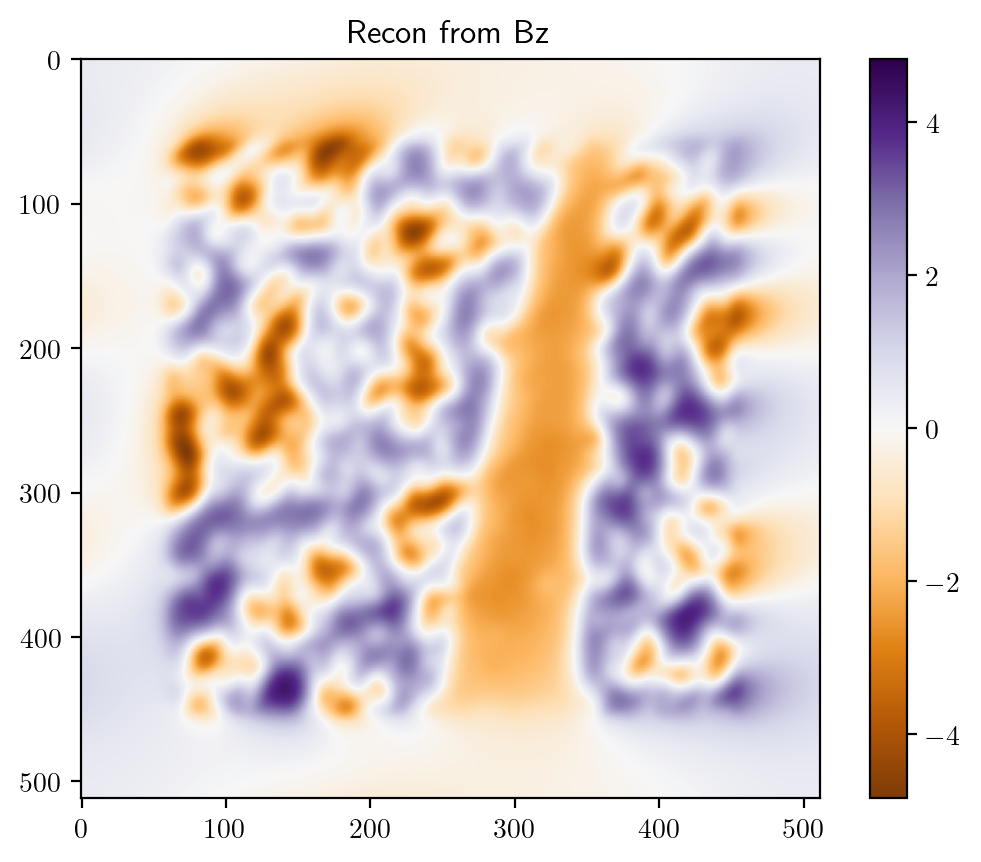

In [34]:
# Define a new dataset object for the reconstruction
Frecon_dataset = Data()
Frecon_dataset.load_data(Bz_data, dx, dy, height, 0, 0, 0)

# Set the transformation to be performed on the data
Frecon_dataset.set_transformer(Bsensor2Mxy, m_theta = 0, m_phi =0)
# Perform the transformation
Frecon_dataset.transform_data()

FMz = Frecon_dataset.transformed_target 

c_range = np.nanmax(np.abs(FMz))

# Plot the reconstructed result
plt.figure()
plt.imshow(FMz, cmap="PuOr", vmin=-c_range, vmax = c_range)
plt.title("Recon from Bz")
plt.colorbar()


## Reconstruction with CNN

In [38]:
# make a new dataset object for the reconstruction
NN_recon_data = Data()
NN_recon_data.load_data(Bz_data, 
                        dx = dx, 
                        dy = dy, 
                        height = height, 
                        theta = 0, 
                        phi = 0, 
                        layer_thickness = 0)

# Define the model of the source that will be reconstructed
Model = UniformMagnetisation(NN_recon_data, 
                             m_theta = 0, 
                             m_phi = 0,
                             scaling_factor = 1e-6,)

# Define the fitting method and pass it the model
FittingMethod = CNN(Model, learning_rate = 0.1)

Number of sources: 1
Number of targets: 1


epoch     1 | loss on last mini-batch:  1.57e+09
epoch    11 | loss on last mini-batch:  2.00e+10
epoch    21 | loss on last mini-batch:  1.69e+09
epoch    31 | loss on last mini-batch:  2.48e+09
epoch    41 | loss on last mini-batch:  4.19e+08
epoch    51 | loss on last mini-batch:  1.06e+08
epoch    61 | loss on last mini-batch:  1.01e+08
epoch    71 | loss on last mini-batch:  2.21e+07
epoch    81 | loss on last mini-batch:  1.92e+07
epoch    91 | loss on last mini-batch:  1.27e+07


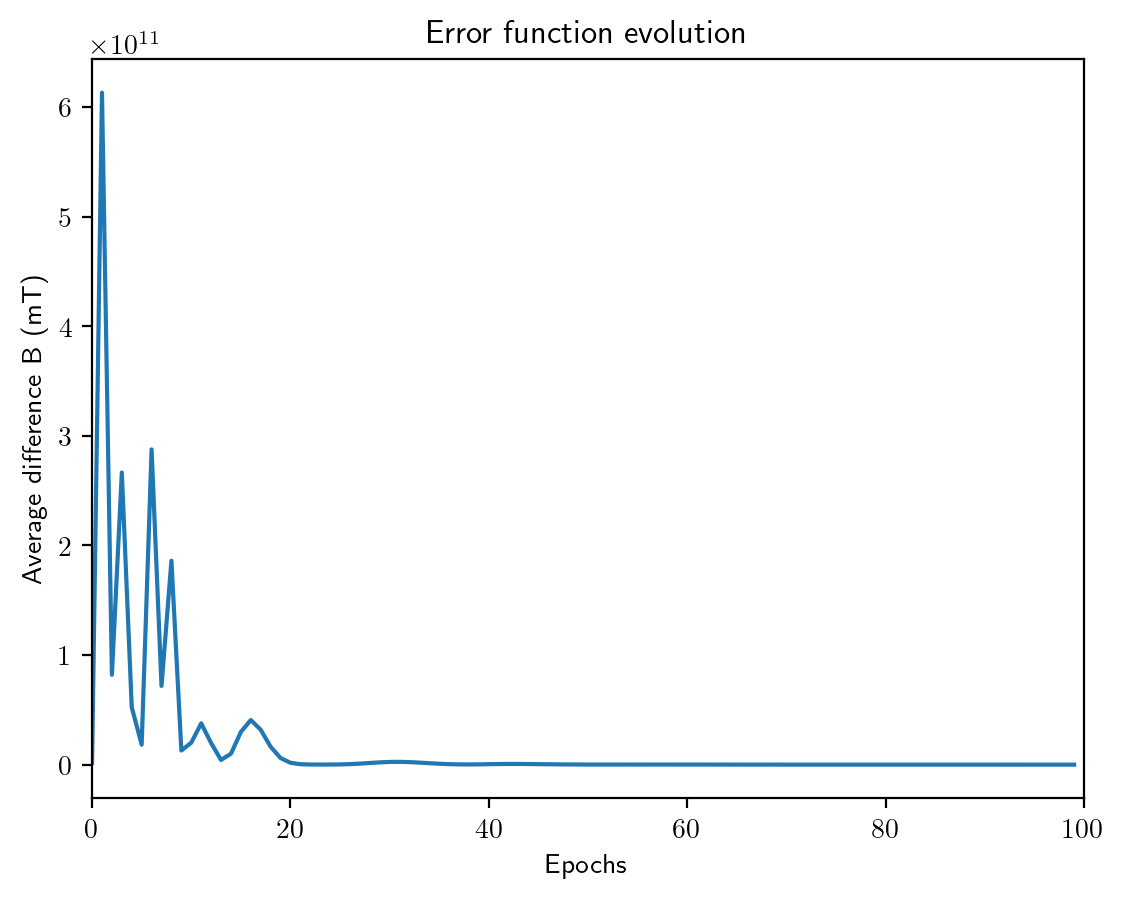

In [39]:
# Perform the fit using the NN
FittingMethod.fit(n_epochs=100)
# Plot the exvolution of the loss function
FittingMethod.plot_loss()

Removed the padding that was applied to the data


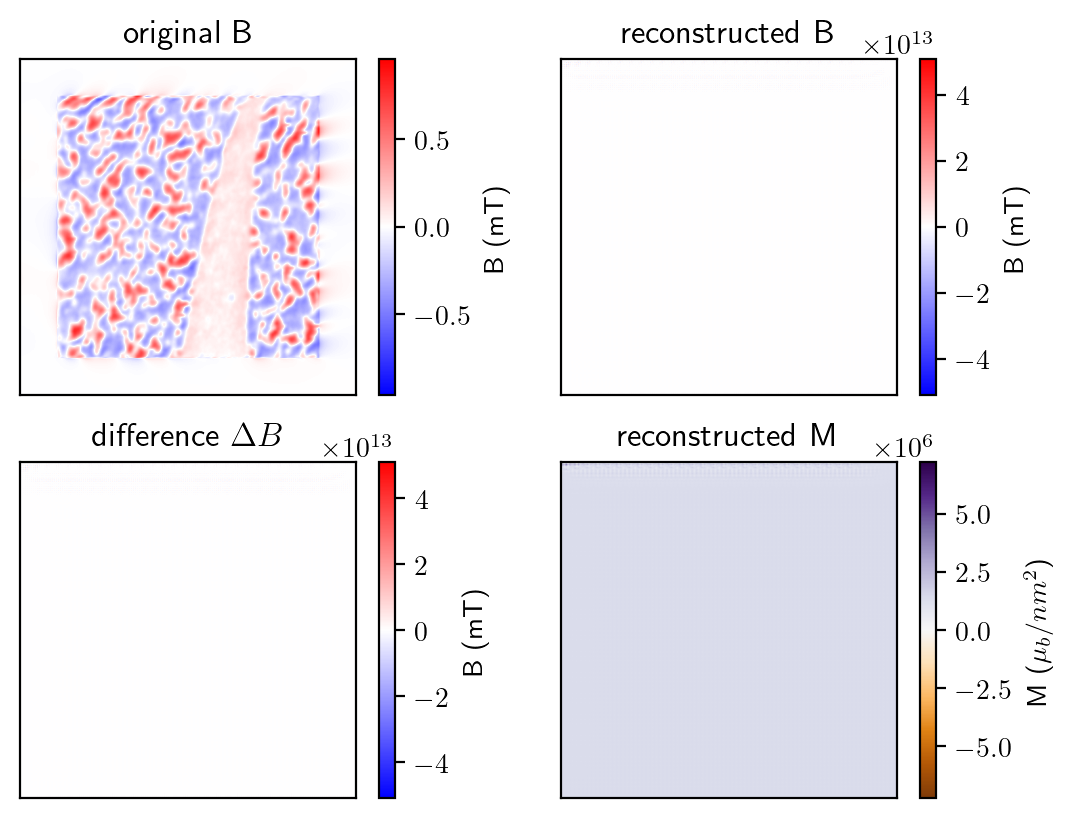

In [40]:
# Plot the results of the reconstruction
FittingMethod.plot_results()

In [44]:

# Define the model of the source that will be reconstructed
Model_2 = UniformMagnetisation(NN_recon_data, 
                             m_theta = 0, 
                             m_phi = 0,
                             scaling_factor = 1,)

# Define the fitting method and pass it the model
FCNN_Method = FCNN(Model_2, learning_rate = 0.1)

Number of sources: 1
Number of targets: 1
Including source angles in the neural network: False


epoch     1 | loss on last mini-batch:  3.70e+05
epoch    26 | loss on last mini-batch:  2.11e+06
epoch    51 | loss on last mini-batch:  2.76e+05
epoch    76 | loss on last mini-batch:  1.59e+04


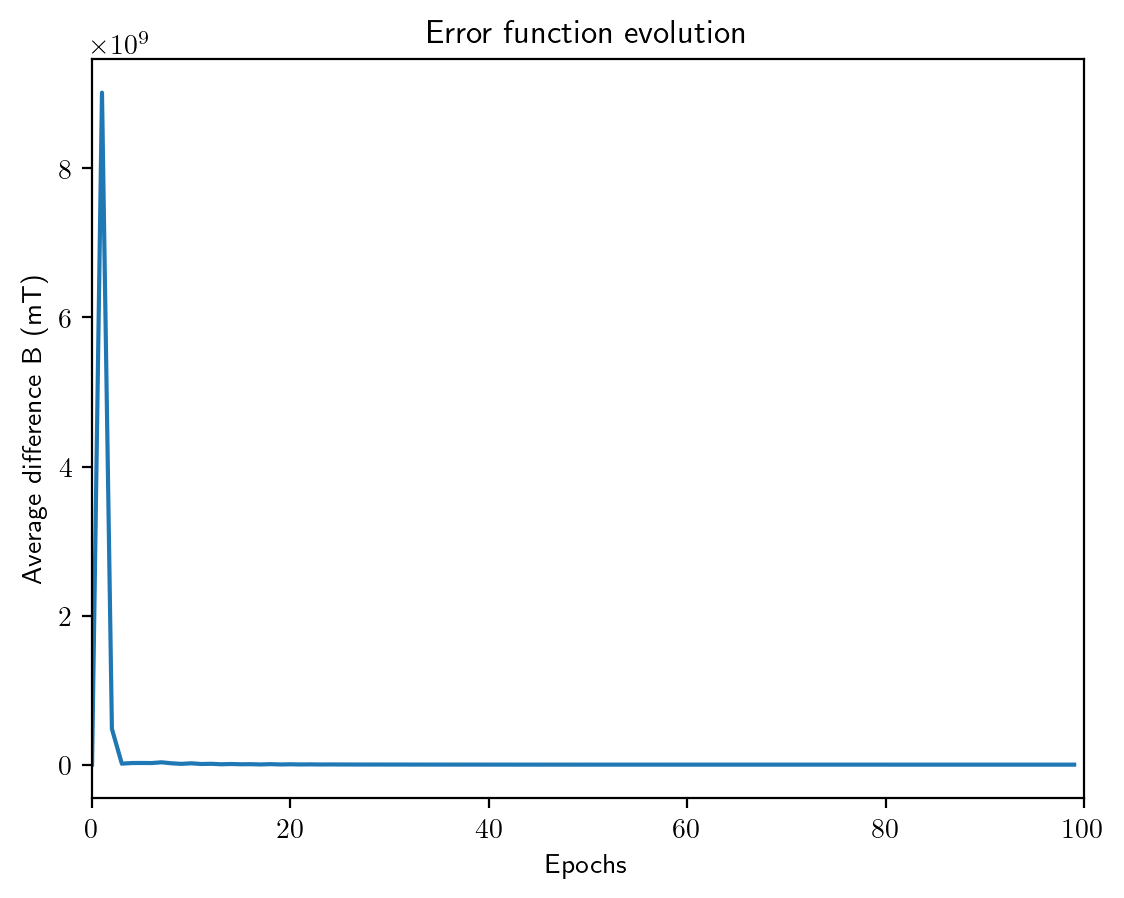

In [45]:
# Perform the fit using the NN
FCNN_Method.fit(n_epochs=100)
# Plot the exvolution of the loss function
FCNN_Method.plot_loss()

Removed the padding that was applied to the data


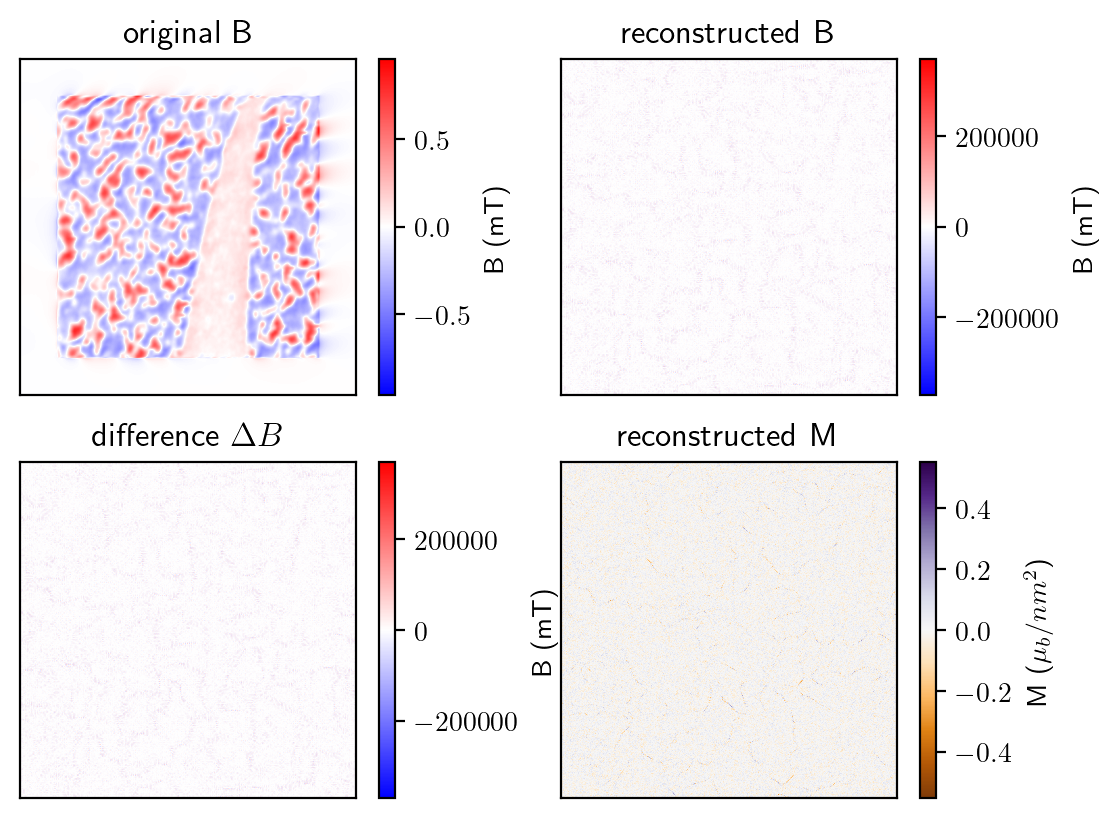

In [46]:
FCNN_Method.plot_results()